# Road Network Detection with Mathematical Morphology

## Libraries

In [ ]:
from skimage.morphology import disk, closing
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

## Raw input & desired output

Text(0.5, 1.0, 'Desired output')

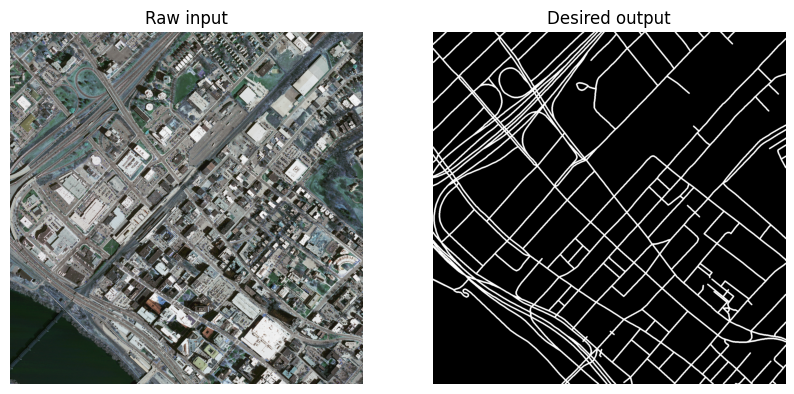

In [ ]:
raw_input = cv2.imread('/content/drive/MyDrive/Colab Projects/Pengcit-UI_Proyek-Akhir/input/img-1.png')
desired_output = cv2.imread('/content/drive/MyDrive/Colab Projects/Pengcit-UI_Proyek-Akhir/ground truth/img-1.png')

plt.figure(figsize=(10, 20))

plt.subplot(1, 2, 1)
plt.imshow(raw_input, cmap='gray')
plt.axis('off')
plt.title('Raw input')

plt.subplot(1, 2, 2)
plt.imshow(desired_output)
plt.axis('off')
plt.title("Desired output")

## Feature extraction with RGB channels intensity distributions

(array([2.005739e+06, 1.897000e+04, 1.753500e+04, 5.523700e+04,
        7.231600e+04, 4.422500e+04, 2.012900e+04, 1.046400e+04,
        4.862000e+03, 5.230000e+02]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

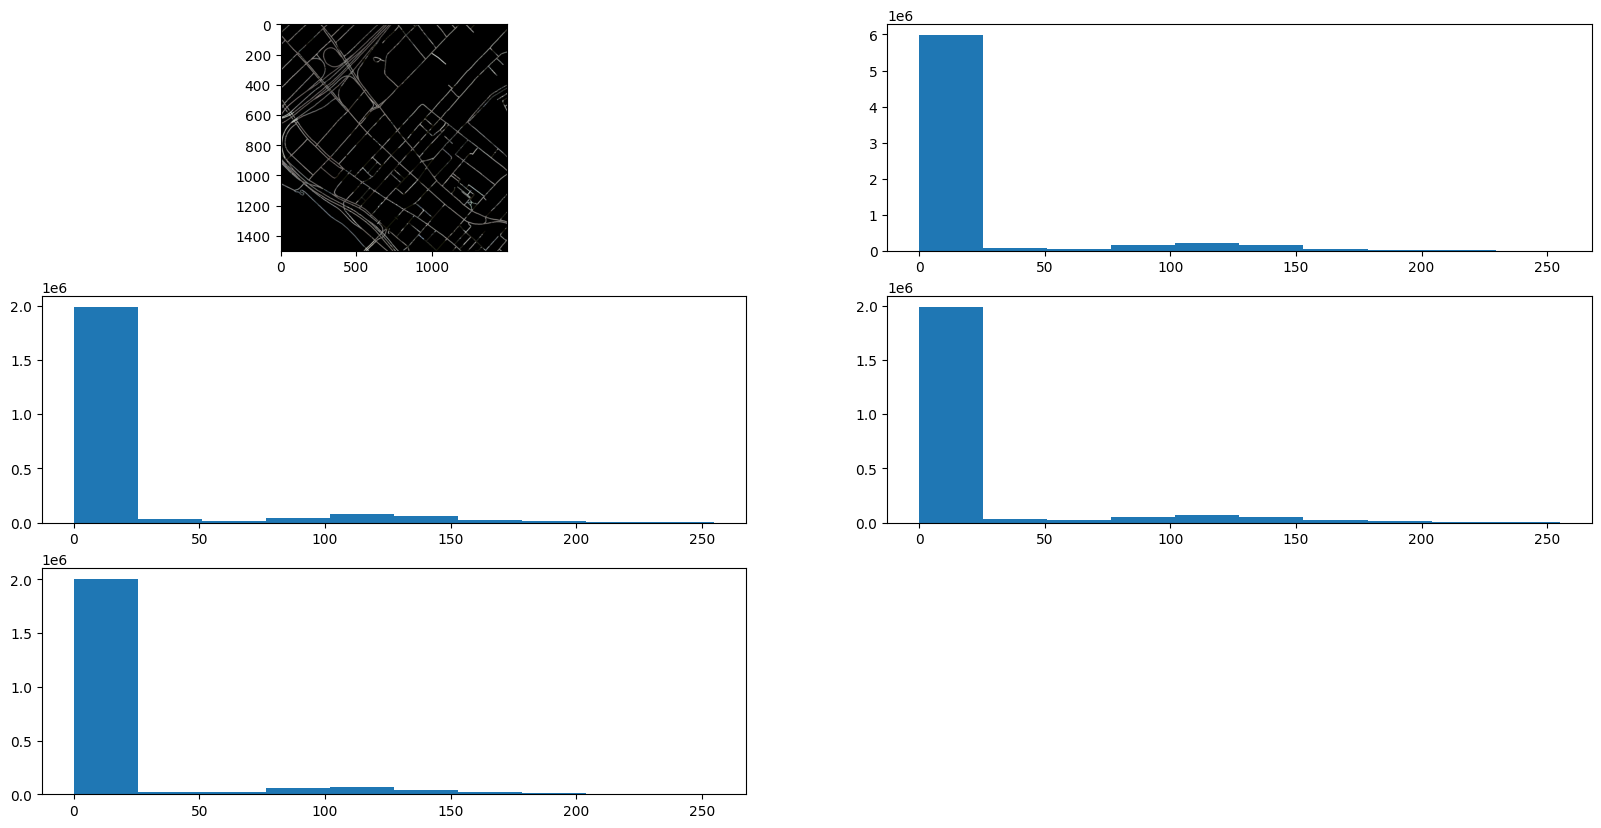

In [ ]:
gray_output = cv2.cvtColor(desired_output, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray_output, 1, 255, cv2.THRESH_BINARY)

road_lines = cv2.bitwise_and(raw_input, raw_input, mask=mask)
R = road_lines[:, :, 0]
G = road_lines[:, :, 1]
B = road_lines[:, :, 2]

plt.figure(figsize=(20, 10))

plt.subplot(3, 2, 1)
plt.imshow(road_lines)

plt.subplot(3, 2, 2)
plt.hist(road_lines.flatten())

plt.subplot(3, 2, 3)
plt.hist(R.flatten())

plt.subplot(3, 2, 4)
plt.hist(G.flatten())

plt.subplot(3, 2, 5)
plt.hist(B.flatten())

## Segmentation by RGB channel

### Build RGB segmentation function:

In [ ]:
def segment_by_rgb(image):
  lower_range = np.array([100, 100, 80], dtype=np.uint8)
  upper_range = np.array([175, 150, 140], dtype=np.uint8)

  color_mask = cv2.inRange(image, lower_range, upper_range)

  color_segmented = cv2.bitwise_and(image, image, mask=color_mask)

  return color_segmented

### Apply RGB segmentation:

In [ ]:
color_segmented = segment_by_rgb(raw_input)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(raw_input)
plt.title('Before (Original Image)')

plt.subplot(1, 2, 2)
plt.imshow(color_segmented)
plt.title('After')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

## RGB to gray conversion

In [ ]:
gray = cv2.cvtColor(color_segmented, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(color_segmented)
plt.title('Before')

plt.subplot(1, 2, 2)
plt.imshow(gray, cmap = 'gray')
plt.title('After')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Closing

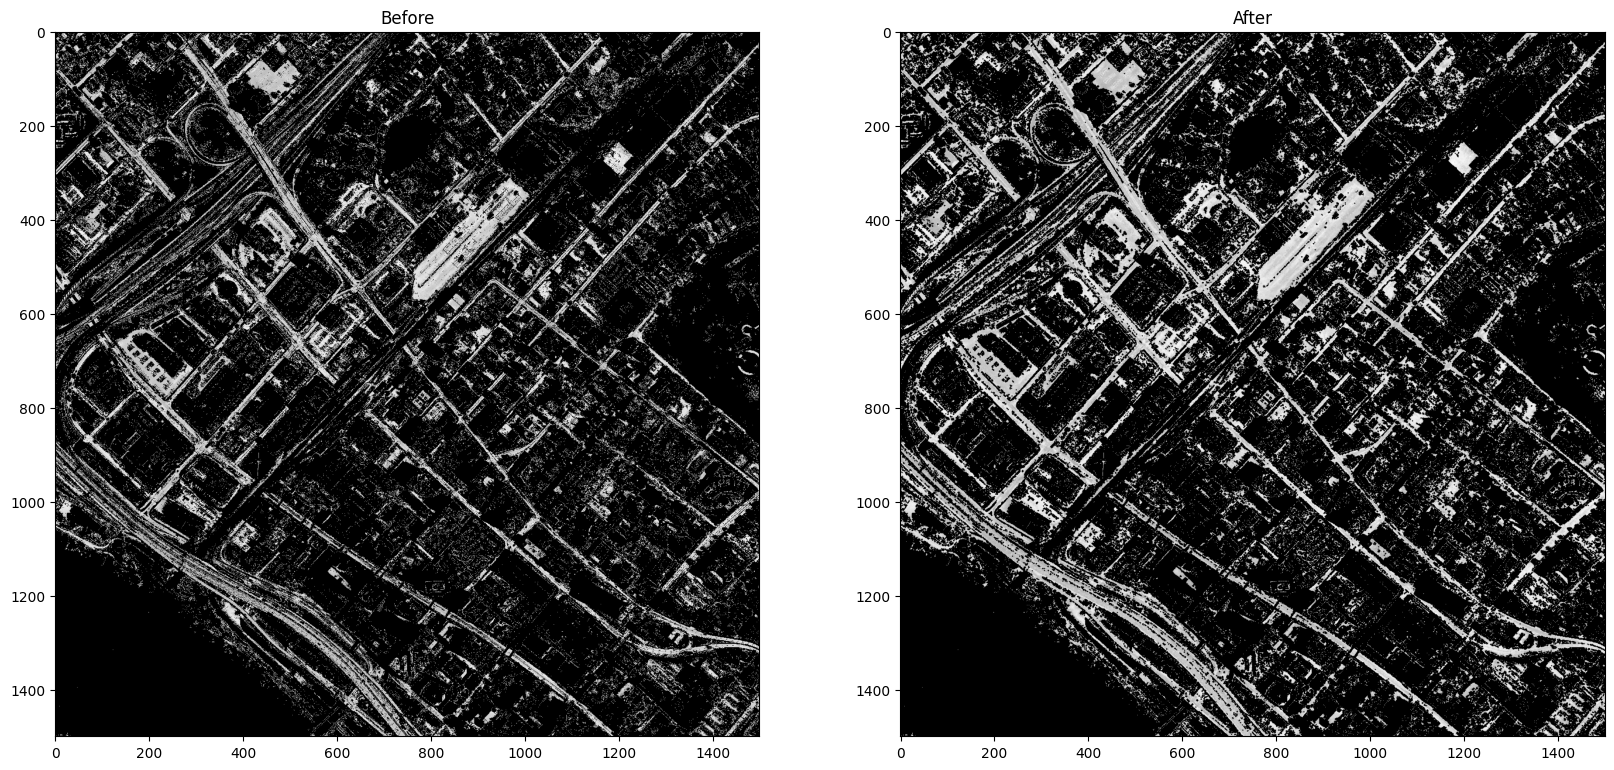

In [ ]:
closed = closing(gray, disk(1))

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title('Before')

plt.subplot(1, 2, 2)
plt.imshow(closed, cmap='gray')
plt.title('After')

plt.show()

## Gray to binary conversion

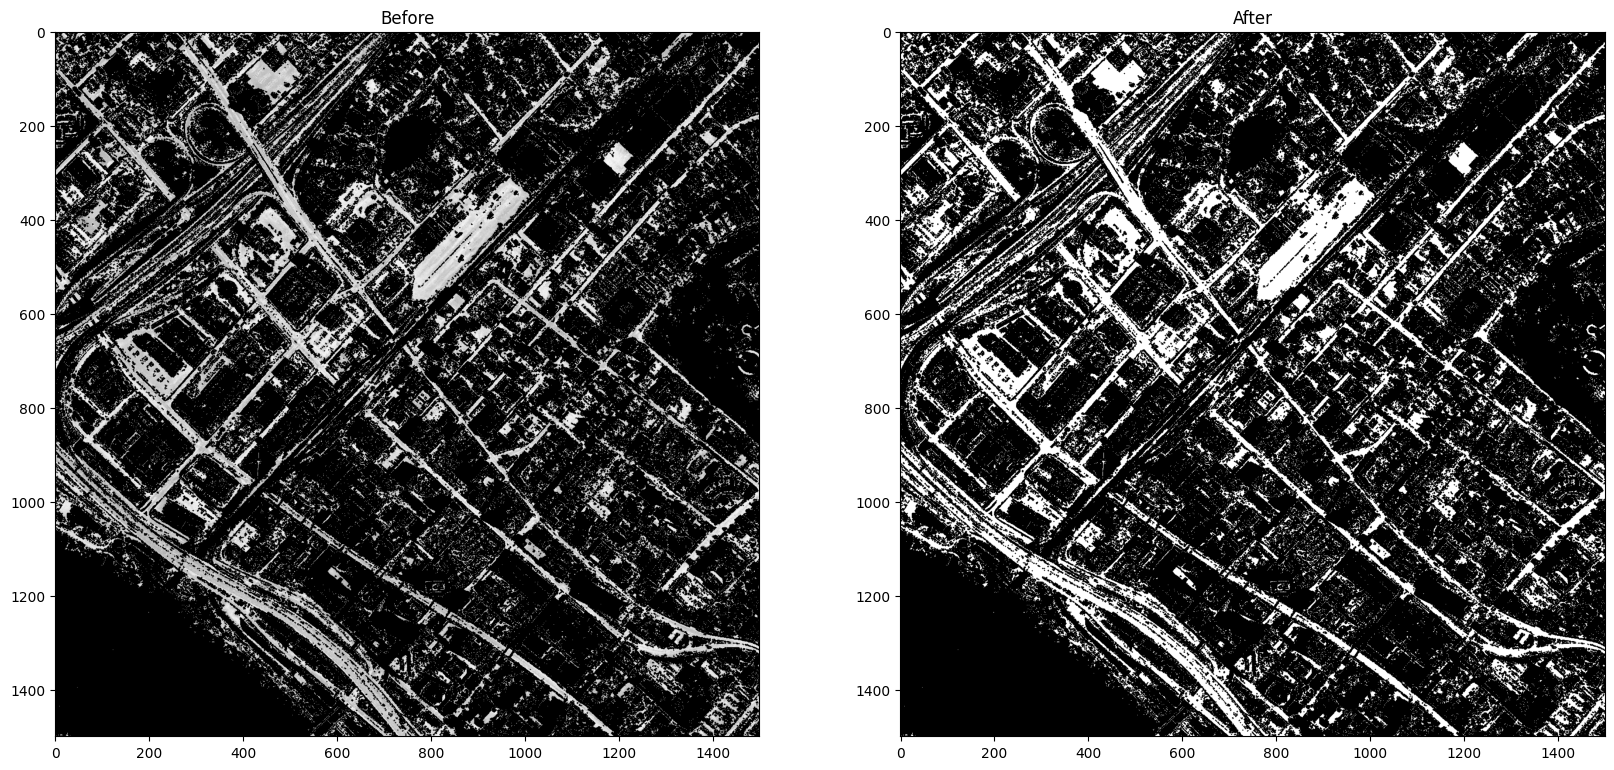

In [ ]:
_, binary = cv2.threshold(closed, 80, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(closed, cmap='gray')
plt.title('Before')

plt.subplot(1, 2, 2)
plt.imshow(binary, cmap='gray')
plt.title('After')

plt.show()

## Connected Component Analysis: Connected component size filtering

### Create connected component filtering function:

In [ ]:
def filter_connected_component_size(binary_image, size_threshold = 250):
  _, binary_mask = cv2.threshold(binary_image, 100, 255, cv2.THRESH_BINARY)
  _, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask)

  for label in range(1, len(stats)):
      area = stats[label, cv2.CC_STAT_AREA]
      if area < size_threshold:
          binary_mask[labels == label] = 0

  size_filtered = cv2.bitwise_and(binary_image, binary_image, mask=binary_mask)

  return size_filtered

### Apply connected component filtering:

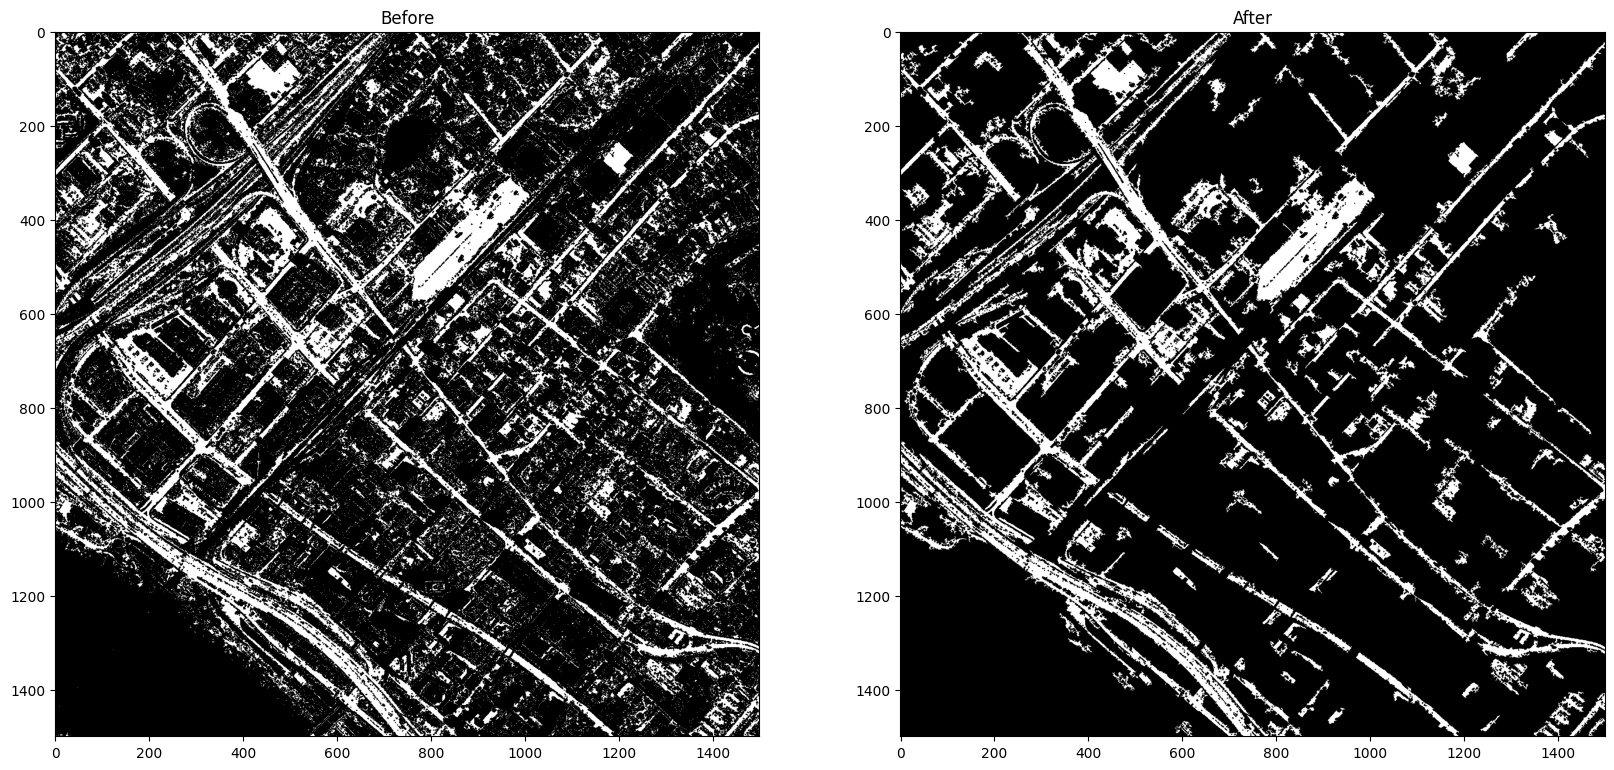

In [ ]:
size_filtered = filter_connected_component_size(binary)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(binary, cmap='gray')
plt.title('Before')

plt.subplot(1, 2, 2)
plt.imshow(size_filtered, cmap='gray')
plt.title('After')

plt.show()

## Final result

### Build segmentation function:

In [ ]:
def get_road_lines(image_path):
  input = cv2.imread(image_path)
  color_segmented = segment_by_rgb(input)
  gray = cv2.cvtColor(color_segmented, cv2.COLOR_BGR2GRAY)
  closed = closing(gray, disk(1))
  _, binary = cv2.threshold(closed, 80, 255, cv2.THRESH_BINARY)
  size_filtered = filter_connected_component_size(binary)

  return (size_filtered)

### Test segmentation function on an image (final result):

In [ ]:
image_path = '/content/drive/MyDrive/Colab Projects/Pengcit-UI_Proyek-Akhir/input/img-1.png'

detected_road_lines = get_road_lines(image_path)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(image_path))
plt.axis('off')
plt.title("Input")

plt.subplot(1, 2, 2)
plt.imshow(detected_road_lines, cmap='gray')
plt.axis('off')
plt.title("Output")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Test Evaluation

### Build metric (IoU) calculator function:

In [ ]:
def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

### Calculate average IoU for 13 test images:

In [ ]:
input_folder = '/content/drive/MyDrive/Colab Projects/Pengcit-UI_Proyek-Akhir/input'
gt_folder = '/content/drive/MyDrive/Colab Projects/Pengcit-UI_Proyek-Akhir/ground truth'

file_names = os.listdir(input_folder)

total_iou = 0
num_images = 0

for file_name in file_names:
    input_image_path = os.path.join(input_folder, file_name)
    gt_image_path = os.path.join(gt_folder, file_name)

    gt_image = cv2.imread(gt_image_path, cv2.IMREAD_GRAYSCALE)

    pred_mask = get_road_lines(input_image_path)
    gt_mask = (gt_image > 0).astype(np.uint8)

    iou = calculate_iou(pred_mask, gt_mask)

    total_iou += iou
    num_images += 1

    print(f"IoU for {file_name}: {iou}")

average_iou = total_iou / num_images

print(f"\nAverage IoU: {average_iou}")


IoU for img-4.png: 0.16567419112465523
IoU for img-2.png: 0.23388093836777096
IoU for img-11.png: 0.15725921931560466
IoU for img-5.png: 0.060395168987727066
IoU for img-9.png: 0.11640802261669315
IoU for img-12.png: 0.1375695748290821
IoU for img-7.png: 0.2077911836605946
IoU for img-6.png: 0.2581377297565822
IoU for img-10.png: 0.12822754206109024
IoU for img-13.png: 0.0758179004109516
IoU for img-3.png: 0.17261661628951883
IoU for img-8.png: 0.28716010879818704
IoU for img-1.png: 0.23453023074676274

Average IoU: 0.17195910976655546
